In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import sklearn.ensemble
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import confusion_matrix
from scipy import signal
from scipy.signal import argrelextrema
from src.dataread import *
from src.plots import *
from src.BollingerBand import *
import src.featuregeneration as fg
from src.fourier import FourierTransform
from src.classifier import Classifier

#### GitHub repository:
https://github.com/DZAlpha/ExoplanetHunting
#### Dataset:
https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data
#### Notebook with properly compiled comments:
https://nbviewer.jupyter.org/github/DZAlpha/ExoplanetHunting/blob/main/exoplanets_hunting.ipynb

# Data
The data are a type of time series that describes the change in light intensivity (henceforth also called flux) of several thousands stars. Observations come from the kaggle data set called "Kepler labelled time series data" and are actually a cleaned version of observations made by the NASA Kepler space telescope. Every row describes one star, and since the rows differ from each other so much, we have to standarize the data row-wise. Each star has a binary label, '1' if the star has no exoplanet in the orbit and '2' if the star is confirmed to have at least one exoplanet in the orbit. Training set consists of 5087 rows with 3198 columns, where column 1 is the label vector and the rest of the columns are flux values over time. It contains 37 exoplanet-stars and 5050 non-exoplanet-stars.

In [2]:
train_df = preprocess(get_train_df())
standarized_train_df = preprocess(get_train_df(), 'standarize')

In [3]:
train_df

,,1,2,3,4,5,6,7,8,9,10,...,3188,3189,3190,3191,3192,3193,3194,3195,3196,3197
ID,LABEL,,,,,,,,,,,,,,,,,,,,,
0,2,0.736523,0.730081,0.689200,0.658990,0.650918,0.596280,0.589561,0.614529,0.625039,0.573526,...,0.626207,0.610756,0.610756,0.692428,0.707468,0.735683,0.701533,0.715714,0.679562,0.650931
1,2,0.532753,0.540847,0.501242,0.530814,0.467952,0.478370,0.456348,0.458303,0.460483,0.477457,...,0.589813,0.543444,0.543444,0.555176,0.587280,0.596288,0.576317,0.605424,0.620715,0.627014
2,2,0.654833,0.656359,0.646036,0.638216,0.619388,0.623831,0.623133,0.633317,0.610135,0.632386,...,0.373689,0.413233,0.413233,0.393135,0.397327,0.409395,0.401551,0.393591,0.374466,0.362068
3,2,0.931470,0.964146,0.893628,0.887021,0.917724,0.909832,0.924910,0.907656,0.909394,0.926476,...,0.429184,0.414404,0.414404,0.467293,0.451605,0.400407,0.406513,0.393142,0.393080,0.442132
4,2,0.256688,0.254720,0.252393,0.261119,0.274858,0.283299,0.296523,0.287606,0.299731,0.306570,...,0.444330,0.514840,0.514840,0.531093,0.499437,0.501346,0.515554,0.521064,0.511134,0.475003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5082,1,0.192662,0.190720,0.216761,0.182729,0.236480,0.236040,0.222772,0.270841,0.304433,0.339326,...,0.617571,0.630967,0.648725,0.646325,0.647644,0.639196,0.316290,0.329943,0.367017,0.396430
5083,1,0.904041,0.861872,0.869355,0.845140,0.803833,0.744330,0.735784,0.677318,0.691825,0.645488,...,0.470030,0.479281,0.448762,0.465187,0.415651,0.423198,0.497589,0.524174,0.461856,0.496543
5084,1,0.457990,0.460240,0.452298,0.440223,0.461572,0.453846,0.447998,0.448955,0.440521,0.440965,...,0.311459,0.298246,0.300774,0.339675,0.332339,0.322856,0.356632,0.367707,0.363143,0.363319


In [4]:
test_df = preprocess(get_test_df(), 'normalize')
standarized_test_df = preprocess(get_test_df(), 'standarize')

# Some examples


There is an exoplanet


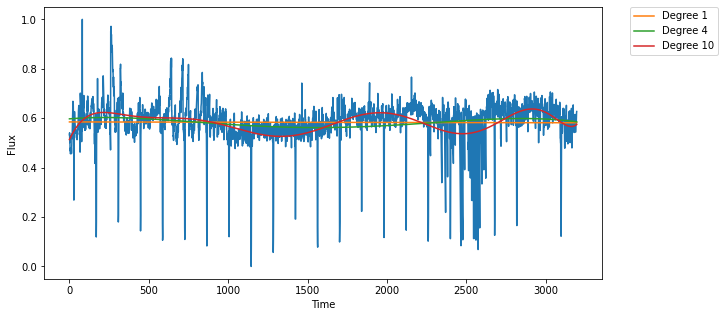

In [5]:
plot_row(train_df, 1)

There is an exoplanet


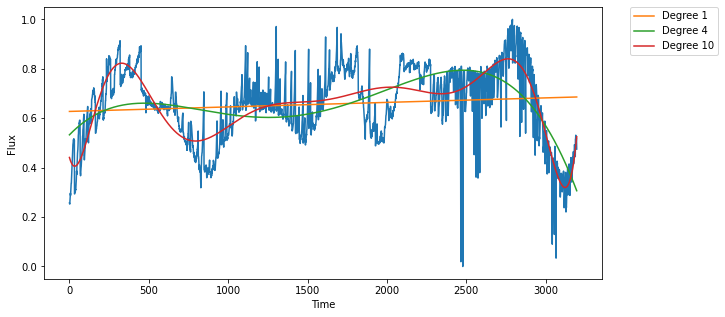

In [6]:
plot_row(train_df, 4)

There is an exoplanet


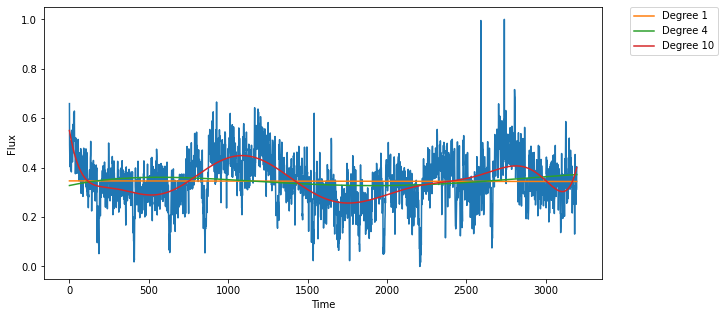

In [7]:
plot_row(train_df, 19)

There's no exoplanet


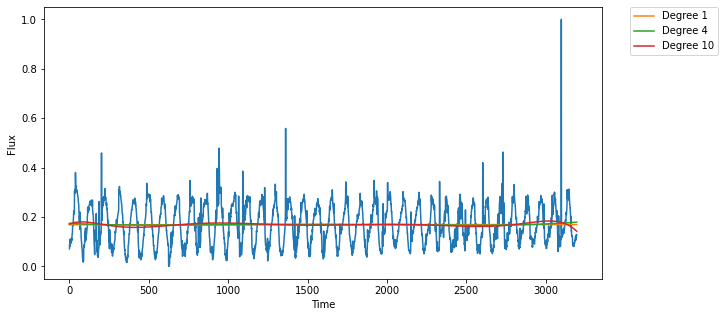

In [8]:
plot_row(train_df, 40)

There's no exoplanet


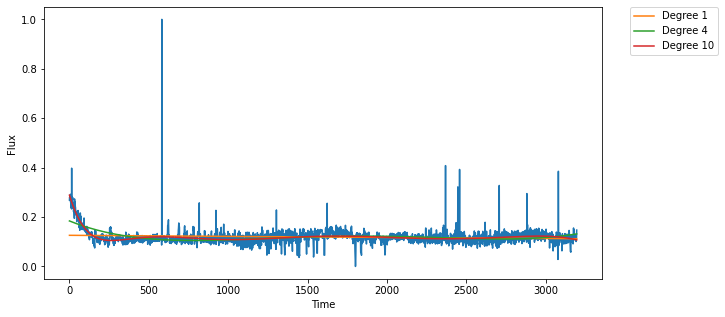

In [9]:
plot_row(train_df, 45)

# Features
'features' DF shows all of the features ("BB" - Bollinger Band) that we extracted and used in the final classifier. We explain the process of generating these features, as well as why we even use them, below. 

In [10]:
train_features = fg.Features(train_df, standarized_train_df)
test_features = fg.Features(test_df, standarized_test_df)

In [11]:
train_features.features

,Label,Flux: STD,Flux: variance,Flux: mean,Flux: No. BB Outliers,Flux: STD of BB outliers,Flux: mean of BB outliers,Fourier: STD,Fourier: mean,Fourier: No. BB outliers
0,2,0.103135,0.010637,0.682690,6,97.019031,100.000000,32.051846,31.361299,0
1,2,0.096185,0.009252,0.583164,37,52.941145,39.346154,40.486935,33.543942,23
2,2,0.131133,0.017196,0.410850,22,90.781960,58.264151,30.307229,20.750008,3
3,2,0.161639,0.026127,0.412969,17,104.827293,70.658537,18.174195,13.065474,1
4,2,0.148961,0.022189,0.656592,24,148.005043,53.672727,18.445966,17.551577,1
...,...,...,...,...,...,...,...,...,...,...
5082,1,0.133107,0.017717,0.383980,4,182.696945,118.909091,35.556635,28.932504,0
5083,1,0.089216,0.007960,0.484953,4,140.552093,67.021739,39.151443,35.473390,0
5084,1,0.029956,0.000897,0.325984,4,112.767790,122.117647,29.747736,45.840732,0
5085,1,0.020258,0.000410,0.031780,0,246.321112,275.900000,18.286087,52.075197,0


## Discrete Fourier Transform
Since our data can be interpreted as a time series, we decided to use Discrete Fourier Transform to extract additional information about each row. Our intuition was that if observations of one star's light intensity form a wave-like shape, then it would be possible to quantify that property using DFT (since it finds the frequencies that sums up to our signal). We focused on finding the outliers of DFT and then using them to extract new features. Standard deviation and mean value of DFT also proved to be decent features. <br>

Here are some examples of DFT together with Bollinger bands which we used to identify the outliers.
The spike at the beginning of every DFT is probably caused by the fact that our observations are not periodic. Because of that, we decided to skip the first dozen or so points of every DFT while processing it to calculate new features. 

There is an exoplanet
std =  52.556554309862385


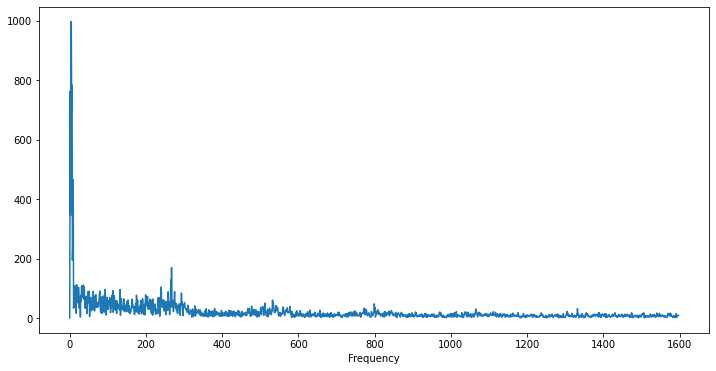

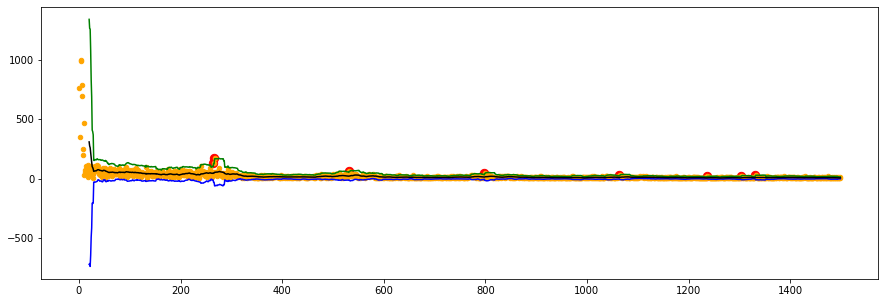

In [12]:
train_features.dft.plot_row(4)
plot_band(train_features.dft.fourier_df.iloc[4][1:1500])

There is no exoplanet
std =  35.548247654318736


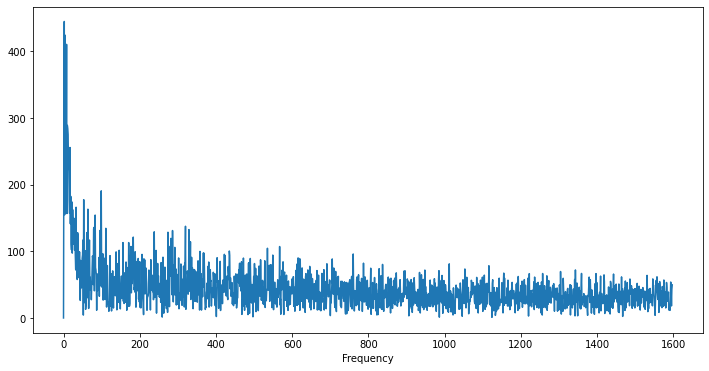

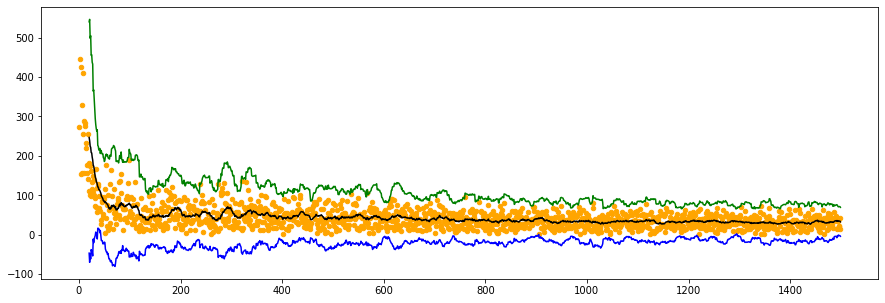

In [13]:
train_features.dft.plot_row(45)
plot_band(train_features.dft.fourier_df.iloc[45][1:1500])

## Outliers
Each row represents light intensity emited by some star, observed by the telescope. Key observation is, that if there exists an exoplanet around a given star, drops of brightness will be observed when exoplanet is between the telescope and a star. Therefore, by finding outliers, and more precisely, outliers that have values smaller than the mean, we identify candidates to be exoplanets. That's a first step in our analysis. 

### Bollinger Band
Mostly used in financial trading, bollinger bands are a type of statistical chart that describes values of some given time series. The middle band is determined by calculating moving average within the given span, then we can establish the upper band by adding and lower band by subtracting k-multiplied standard deviation of values (from our given time window) to the middle band.

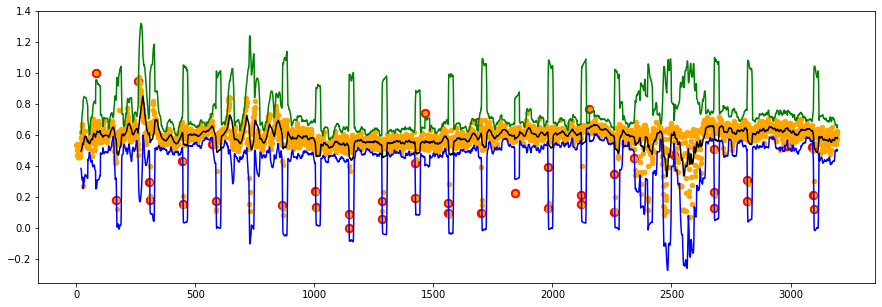

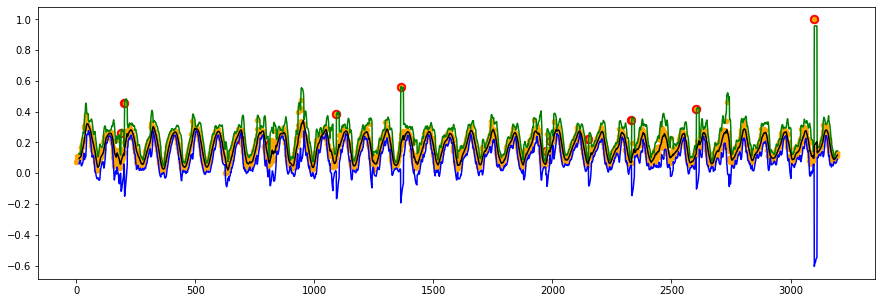

In [14]:
plot_band(train_df.iloc[1])
plot_band(train_df.iloc[40], span=12)

### Properties of outliers
After finding outliers we need to analyse them, as some may be simply noise. What interests us, is some regularity in them. In perfect example, when there is no noise, outliers would occur at equal distances in time from each other, as exoplanet circles a star. Therefore, if we look at distances between outliers and compute their standard deviation, it would be zero if distances are all the same, and the more irregularity, the bigger standard deviation we get.

# Testing dataset
Testing dataset consists of 570 rows. Only 5 rows describe a star that has an exoplanet orbiting around it - 565 doesn't have one. Because of such a massive disproportion in label distribution, we used recall and precision to measure the performance of our models (more about these measures below). 

# AdaBoost

In [15]:
ada_boost = Classifier(sklearn.ensemble.AdaBoostClassifier, n_estimators = 1000)
ada_boost.fit_df(train_features.features)

In [16]:
ada_boost.predict_df(test_features.features)

array([1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Confusion matrix


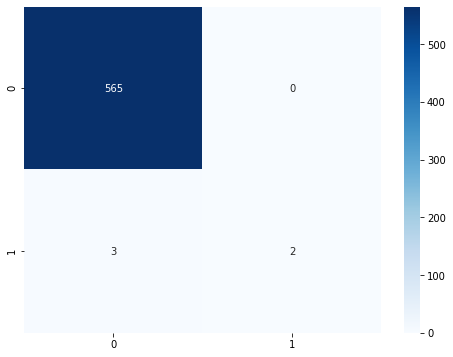

In [17]:
print("Confusion matrix")
ada_boost.plot_cfm()

# Performance of our model
$$
Let\ tp,\ fp,\ tn,\ fn\ be\ respectively\ true\ positives,\ false\ positives,\ true\ negatives,\ false\ negatives\\ 
Precision: \frac{tp}{tp + fp}\\
Recall: \frac{tp}{tp + fn}\\
F-Score: \frac{2}{\mathrm{recall}^{-1} + \mathrm{precision}^{-1}} = \frac{\mathrm{tp}}{\mathrm{tp} + \frac12 (\mathrm{fp} + \mathrm{fn})}\\
True\ negative\ rate: \frac{tn}{tn + fp}\\
$$

### Measures for AdaBoost:

In [18]:
f_score, precision, recall, true_negative_rate = ada_boost.get_measures()
print(f"For AdaBoost:\nF-score: {f_score}\nPrecision: {precision}\nRecall: {recall}\nTrue negative rate: {true_negative_rate}")

For AdaBoost:
F-score: 0.5714285714285715
Precision: 1.0
Recall: 0.4
True negative rate: 1.0


### Random classifier F-score:

In [19]:
mean_f_score = 0
test = ada_boost
for i in range(1000):
    cfm = confusion_matrix(test.true_y, np.random.randint(1, 3, size = 570))
    tn, fp, fn, tp = cfm[0][0], cfm[0][1], cfm[1][0], cfm[1][1]
    precision = tp / (tp + fp + 1e-20)
    recall = tp / (tp + fn + 1e-20)
    precision, recall
    f_score = 2*((precision * recall)/(precision + recall + 1e-20) )
    mean_f_score += f_score / 1000
print(mean_f_score)

0.016577298993279924


# Features ranking in descending order

In [20]:
X, Y = Classifier.df_to_ndarray(test_features.features)
selector = SelectKBest(chi2, k = 1)
selector.fit(X, Y)
sorted_features = np.argsort(selector.scores_)[::-1] + 1
for column in test_features.features.columns[sorted_features]:
    print(column)

Fourier: No. BB outliers
Flux: STD of BB outliers
Flux: mean of BB outliers
Flux: No. BB Outliers
Fourier: STD
Fourier: mean
Flux: mean
Flux: STD
Flux: variance


Flux: STD


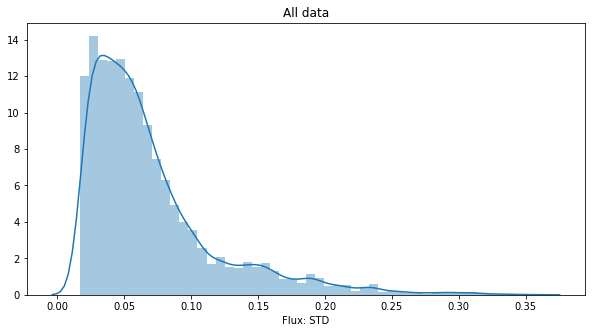

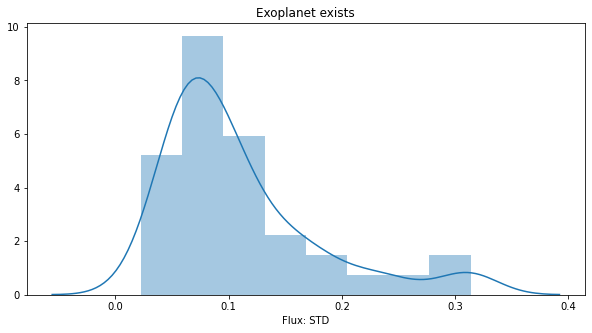

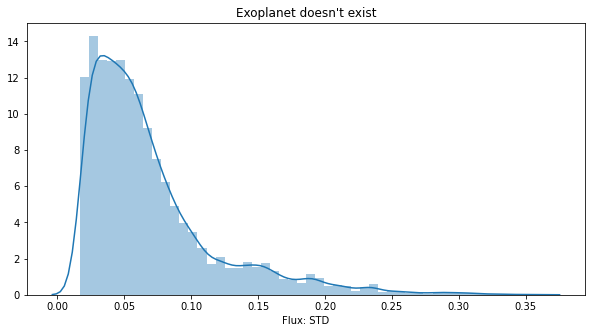

Flux: variance


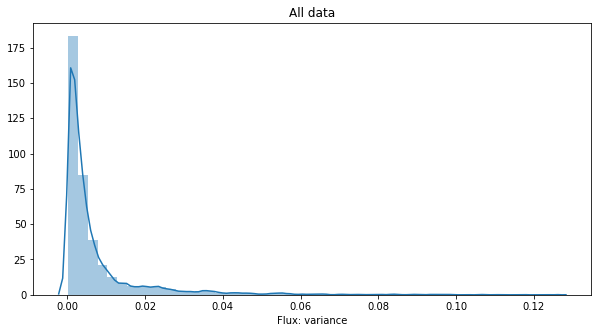

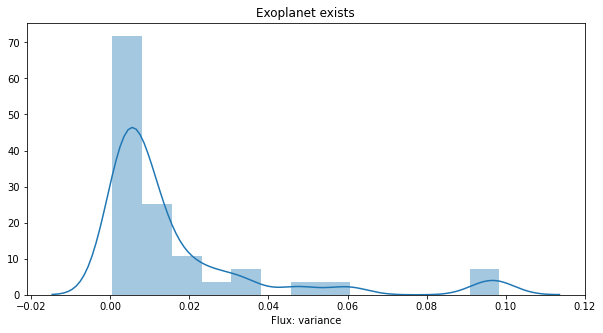

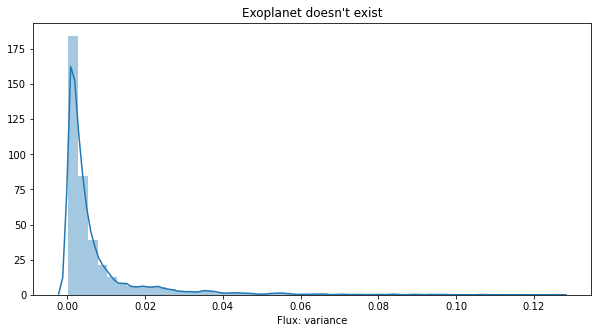

Flux: mean


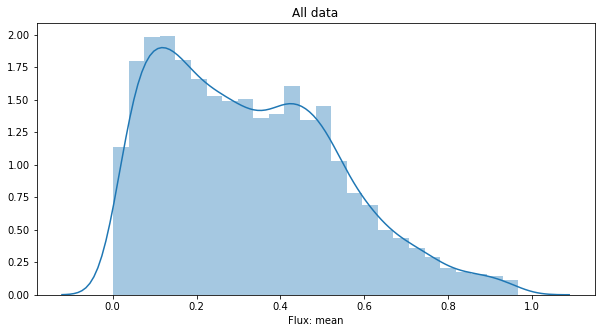

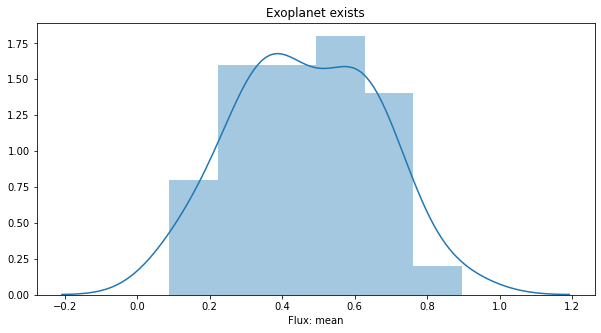

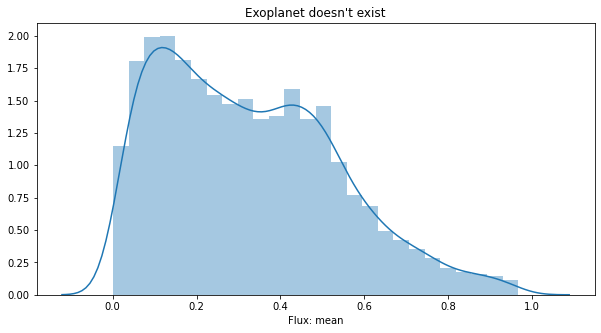

Flux: No. BB Outliers


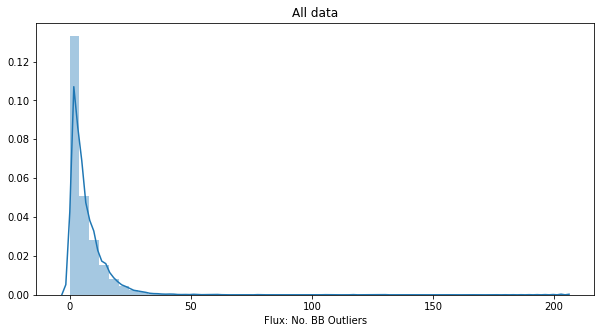

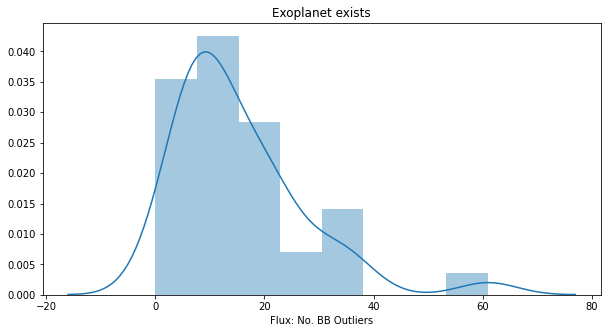

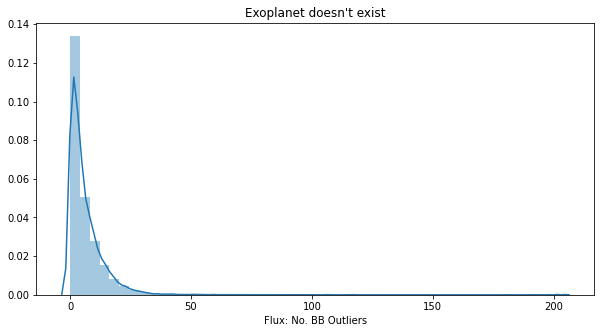

Flux: STD of BB outliers


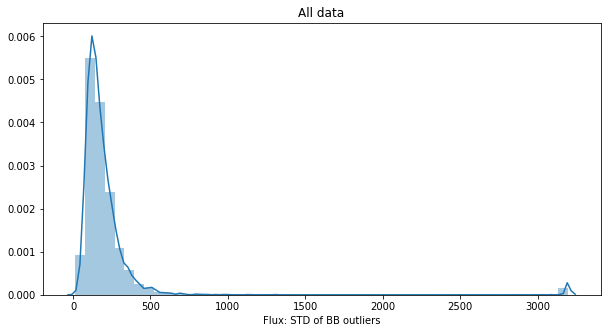

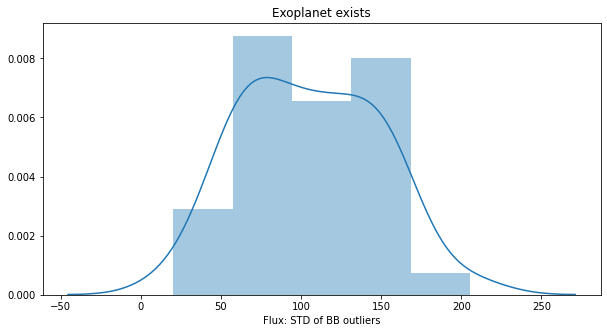

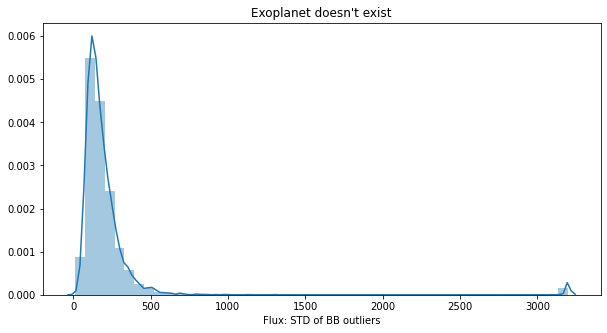

Flux: mean of BB outliers


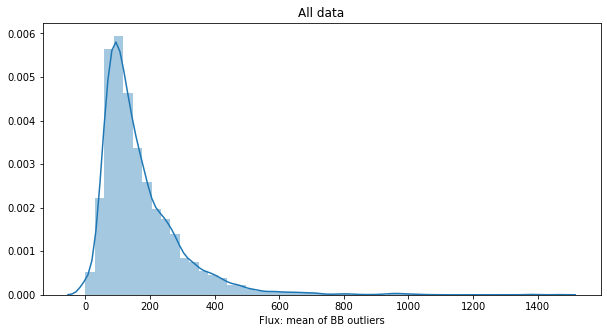

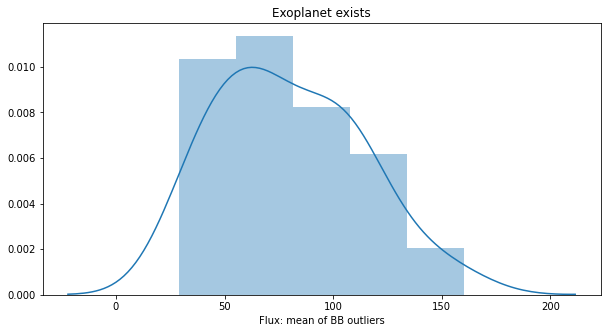

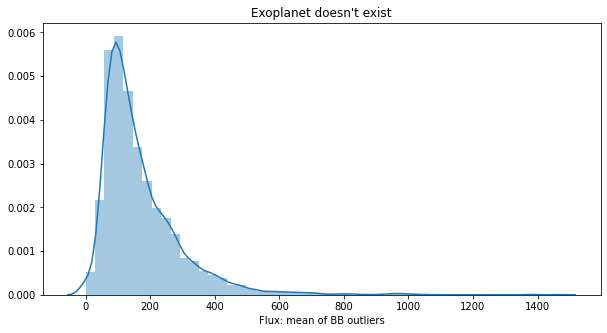

Fourier: STD


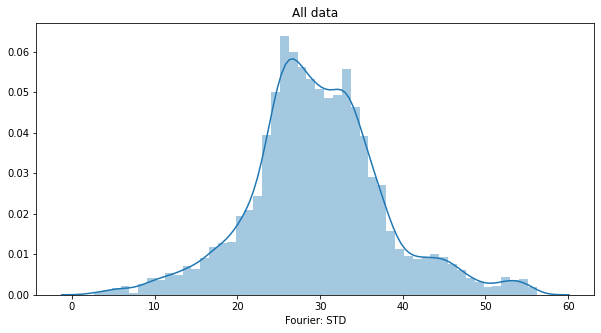

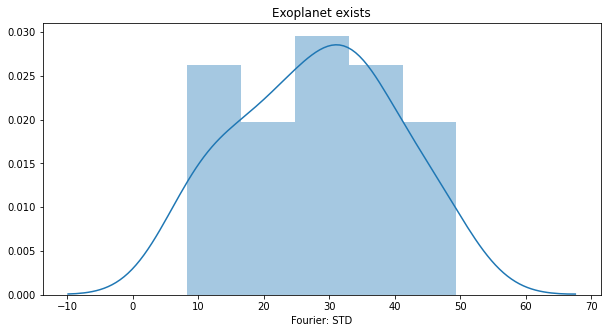

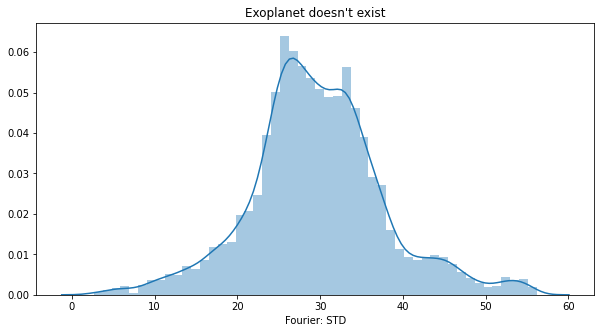

Fourier: mean


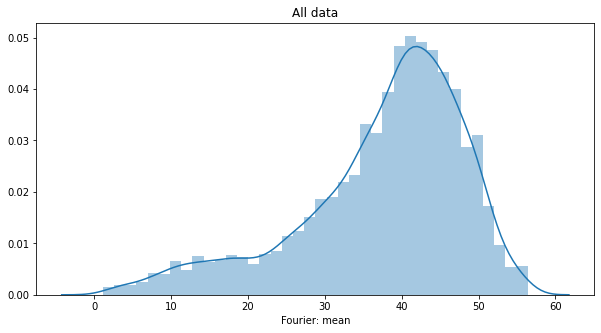

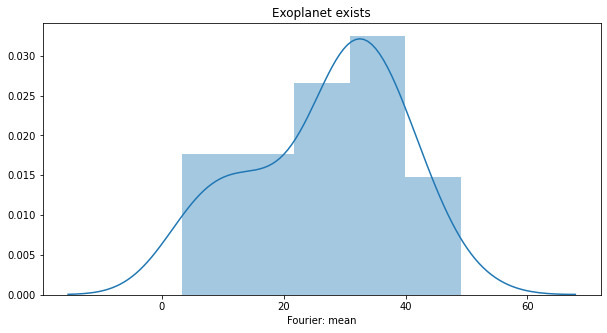

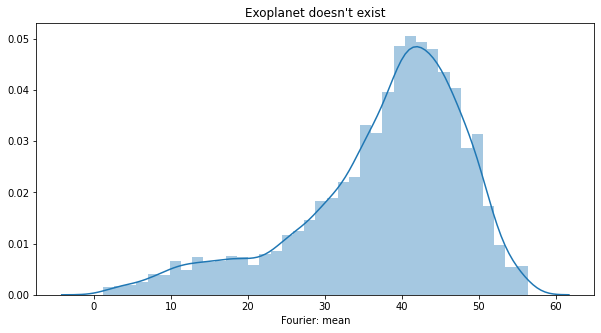

Fourier: No. BB outliers


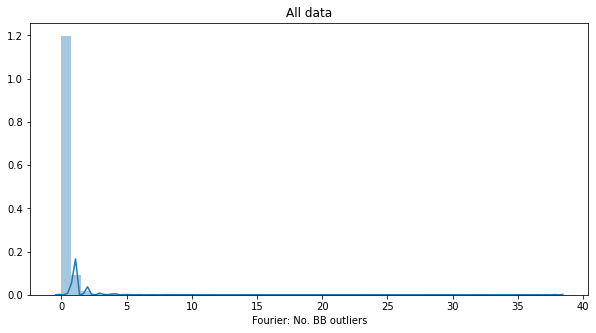

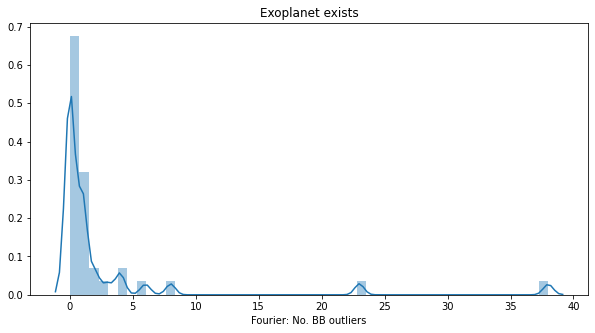

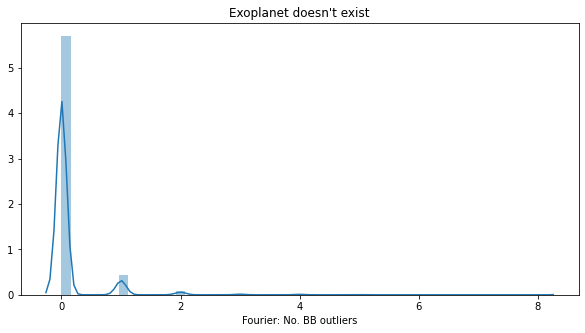

In [21]:
plot_histograms(train_features.features)